In [1]:
import sys
sys.path.append("../")
import os
import numpy as np
import nibabel as nb
import pandas as pd
import matplotlib.pylab as plt
import SimpleITK as sitk
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from data.nifti_dataset import resample_nifti
from data.base_dataset import _roll2center_crop
from scipy.ndimage.measurements import center_of_mass
from skimage.measure import label, regionprops

import DeepStrain.functions_collection as ff

/usr/local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
main_path = '/mnt/camca_NAS/SAM_for_CMR/models/sam_multiview_prompt_text_HF_LAX_finetune/predicts_HFpEF_lax'

### load segmentation

In [20]:
patient_id = 'ID_0007'
seg_file = nb.load(os.path.join(main_path,patient_id, 'epoch-100/LAX4_seg_pred.nii.gz'))
seg_data = seg_file.get_fdata(); seg_data = np.round(seg_data).astype(np.int)
print(seg_data.shape)


(256, 216, 15)


/tmp/ipykernel_146571/2922149634.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  seg_data = seg_file.get_fdata(); seg_data = np.round(seg_data).astype(np.int)


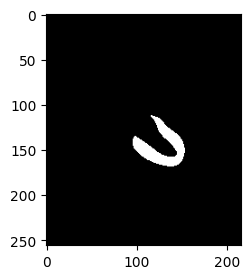

In [70]:
tf = 7
plt.figure(figsize=(3,3))
plt.imshow(seg_data[:,:,tf],cmap = 'gray')
plt.show()
binary_image = seg_data[:,:,tf]

### get the connected componenet (remove the small ones)

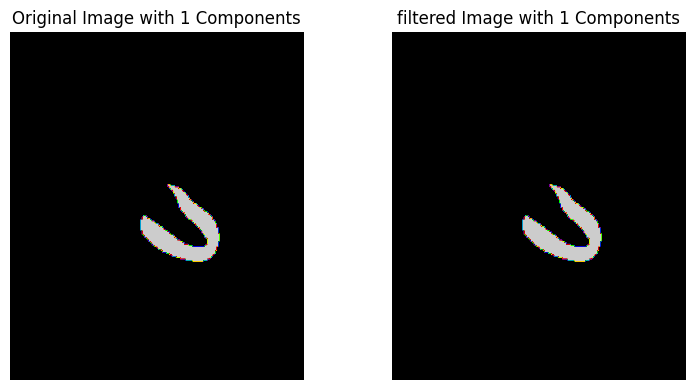

In [71]:
import numpy as np
from scipy import ndimage

def filter_components(binary_image, threshold):
    # Step 1: Identify connected components
    labeled_array, num_components = ndimage.label(binary_image)
    
    # Initialize lists to store pixels and pixel counts for each component
    component_pixels = []
    component_pixel_counts = []

    # Create a copy of the binary image for modification
    filtered_image = binary_image.copy()

    # Step 2: Process each connected component
    for label in range(1, num_components + 1):
        # Create a mask for the current component
        mask = labeled_array == label
        
        # Get pixel coordinates of the component
        pixels = np.argwhere(mask)
        
        # Get the number of pixels in the component
        pixel_count = np.sum(mask)
        
        # Store the component's pixels and pixel count
        component_pixels.append(pixels)
        component_pixel_counts.append(pixel_count)
        
        # Step 3: Filter based on threshold
        if pixel_count < threshold:
            # Set pixels of the component to 0 if below threshold
            filtered_image[mask] = 0

    return labeled_array, num_components, component_pixels, component_pixel_counts, filtered_image

# Example usage
# binary_image is a 2D NumPy array where background=0 and myocardium=1
# threshold is an integer, e.g., 50
labeled_array1, num_components1, component_pixels1, component_pixel_counts1, filtered_image = filter_components(binary_image, threshold = 30)
labeled_array, num_components, component_pixels, component_pixel_counts, filtered_image = filter_components(filtered_image, threshold = 30)
# Plot original labeled image and filtered image side by side
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# Plot the original labeled image
axes[0].imshow(labeled_array1, cmap='nipy_spectral')
axes[0].set_title(f'Original Image with {num_components1} Components')
axes[0].axis('off')

# Plot the new filtered binary image
axes[1].imshow(labeled_array, cmap='nipy_spectral')
axes[1].set_title(f'filtered Image with {num_components} Components')
axes[1].axis('off')

plt.tight_layout()
plt.show()

### skeletonize

In [73]:
def extract_skeleton_points(binary_image):
   
    # Apply skeletonization to the binary image
    skeleton = skeletonize(binary_image)
    
    # Find the coordinates of the skeleton points
    skeleton_points = np.argwhere(skeleton)
    
    return skeleton_points

# Initialize an array to store skeleton points for all components
all_skeleton_points = []

# Process each connected component in the filtered image
for label in range(1, num_components + 1):
    # Create a mask for the current component
    component_mask = labeled_array == label
    
    # Extract skeleton points for the current component
    skeleton_points = extract_skeleton_points(component_mask)
    
    # Add the skeleton points to the list
    all_skeleton_points.extend(skeleton_points)

# Convert the list to a NumPy array
all_skeleton_points = np.array(all_skeleton_points)
new_seg = np.copy(filtered_image)
new_seg[all_skeleton_points[:,0],all_skeleton_points[:,1]] = 2

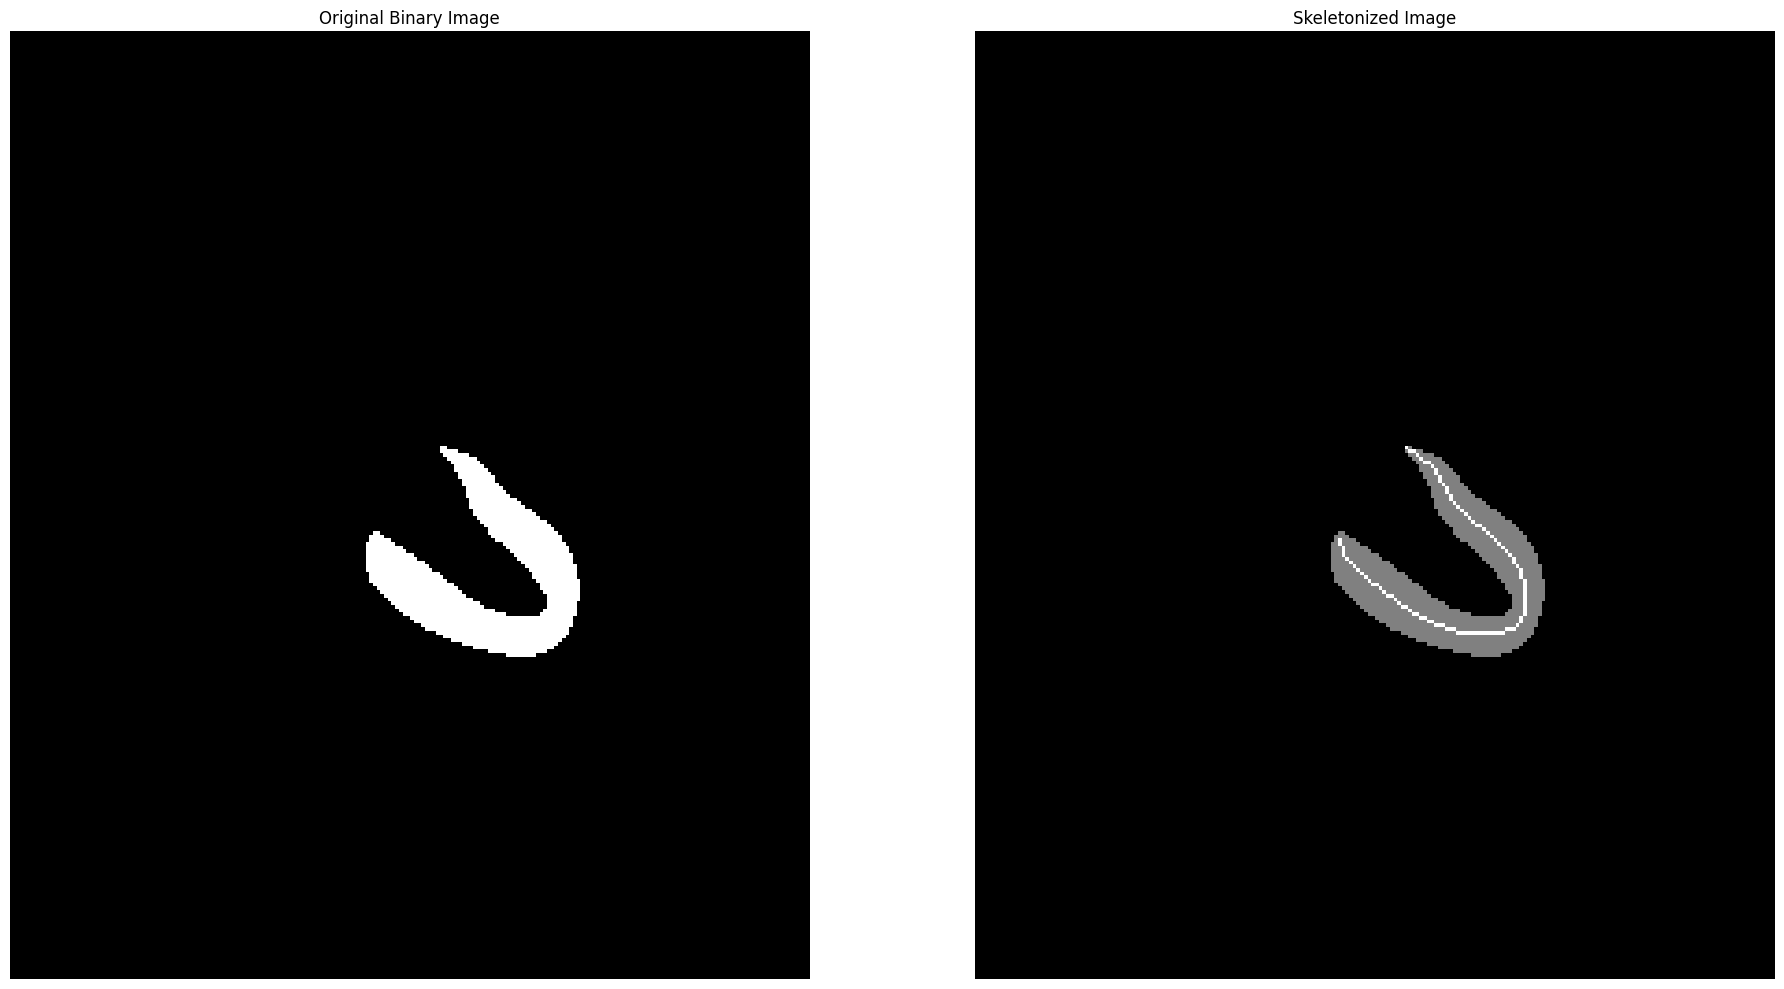

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(20,10), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(filtered_image, cmap='gray')
ax[0].set_title('Original Binary Image')
ax[0].axis('off')

ax[1].imshow(new_seg, cmap='gray')
ax[1].set_title('Skeletonized Image')
ax[1].axis('off')

plt.tight_layout()
plt.show()

### connected skeleton

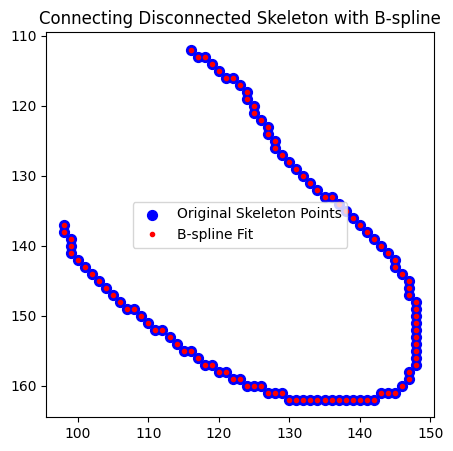

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
from scipy.spatial import distance_matrix

def sort_points_by_shortest_path(x, y):
    
    # Combine x and y into coordinates array
    coords = np.column_stack((x, y))

    # Calculate the distance matrix for all skeleton points
    dist_matrix = distance_matrix(coords, coords)

    # Start from the first point and find the shortest path to sort the coordinates
    sorted_indices = [0]
    for _ in range(1, len(x)):
        last_index = sorted_indices[-1]
        # Set distances from the already visited points to infinity to avoid revisiting
        dist_matrix[:, last_index] = np.inf
        next_index = np.argmin(dist_matrix[last_index])
        sorted_indices.append(next_index)

    # Reorder x and y according to the shortest path
    x_sorted = x[sorted_indices]
    y_sorted = y[sorted_indices]

    return x_sorted, y_sorted

def connect_skeleton_points_2d(all_skeleton_points, num_points=300):
  
    # Extract x and y coordinates
    y, x = all_skeleton_points[:, 0], all_skeleton_points[:, 1]

    # Sort the points using the nearest-neighbor approach
    x_sorted, y_sorted = sort_points_by_shortest_path(x, y)

    # Apply B-spline fitting on the sorted coordinates
    tck, u = splprep([x_sorted, y_sorted], s=0)

    # Generate new points along the B-spline
    u_new = np.linspace(0, 1, num_points)
    x_spline, y_spline = splev(u_new, tck)

    # Combine x and y into a single array of [y, x] coordinates
    spline_points = np.vstack((y_spline, x_spline)).T

    return spline_points


# Connect the skeleton points using B-spline
if num_components >= 2:
    spline_points = connect_skeleton_points_2d(all_skeleton_points)
    spline_x = spline_points[:, 1]
    spline_y = spline_points[:, 0]
else:
    spline_x = all_skeleton_points[:, 1]
    spline_y = all_skeleton_points[:, 0]

# Plot the original skeleton points and the connected B-spline
plt.figure(figsize=(5,5))
plt.scatter(all_skeleton_points[:, 1], all_skeleton_points[:, 0], color='blue', label='Original Skeleton Points', s=50)
plt.plot(spline_x, spline_y,'ro', markersize = 3,linewidth=2, label='B-spline Fit')
plt.gca().invert_yaxis()  # Invert y-axis for image coordinates
plt.title('Connecting Disconnected Skeleton with B-spline')
plt.legend()
plt.show()


### smooth

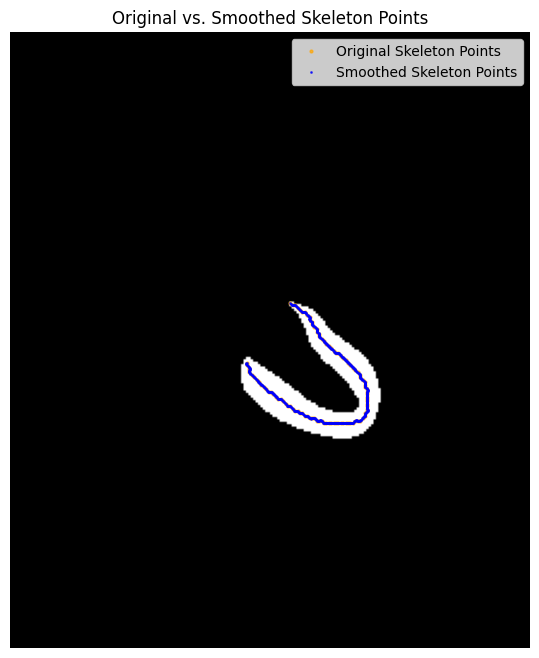

In [80]:
from scipy.spatial import distance_matrix
from scipy.interpolate import interp1d
x = spline_x
y = spline_y

# Calculate the distance matrix for all skeleton points
coords = np.column_stack((x, y))
dist_matrix = distance_matrix(coords, coords)

# Start from the first point and find the shortest path to sort the coordinates
sorted_indices = [0]
for _ in range(1, len(x)):
    last_index = sorted_indices[-1]
    # Set distances from the already visited points to infinity to avoid revisiting
    dist_matrix[:, last_index] = np.inf
    next_index = np.argmin(dist_matrix[last_index])
    sorted_indices.append(next_index)

# Reorder x and y according to the shortest path
x_sorted = x[sorted_indices]
y_sorted = y[sorted_indices]

# Fit a cubic spline to the sorted skeleton coordinates
cubic_spline_x = interp1d(np.linspace(0, 1, len(x_sorted)), x_sorted, kind='cubic')
cubic_spline_y = interp1d(np.linspace(0, 1, len(y_sorted)), y_sorted, kind='cubic')

# Generate the smoothed coordinates
u_new = np.linspace(0, 1, 500)  # Generate 500 points for a smoother line
smooth_x = cubic_spline_x(u_new)
smooth_y = cubic_spline_y(u_new)

# Plot the original and smoothed skeleton
plt.figure(figsize=(8,8))
plt.imshow(binary_image, cmap='gray')
plt.plot(x_sorted, y_sorted, 'o', markersize=2, color='orange', label='Original Skeleton Points', alpha=0.7)
plt.plot(smooth_x, smooth_y, 'o', markersize=1, color='blue', label='Smoothed Skeleton Points', alpha=0.7)
plt.legend()
plt.title('Original vs. Smoothed Skeleton Points')
plt.axis('off')
plt.show()




In [81]:
# Calculate the distance matrix for the smoothed skeleton points
smoothed_coords = np.column_stack((smooth_x, smooth_y))
smoothed_dist_matrix = distance_matrix(smoothed_coords, smoothed_coords)

# Start from the first smoothed point and find the shortest path to sort the coordinates
sorted_smoothed_indices = [0]
for _ in range(1, len(smooth_x)):
    last_index = sorted_smoothed_indices[-1]
    # Set distances from the already visited points to infinity to avoid revisiting
    smoothed_dist_matrix[:, last_index] = np.inf
    next_index = np.argmin(smoothed_dist_matrix[last_index])
    sorted_smoothed_indices.append(next_index)

# Reorder the smooth_x and smooth_y according to the shortest path
smooth_x_sorted = smooth_x[sorted_smoothed_indices]
smooth_y_sorted = smooth_y[sorted_smoothed_indices]

# Calculate the total distance of the smoothed skeleton in mm (pixel dimension = [1,1]mm)
total_distance_mm = np.sum(np.sqrt(np.diff(smooth_x_sorted)**2 + np.diff(smooth_y_sorted)**2))

total_distance_mm

126.09203180642871

In [82]:
(126.09- 152.749791181914) / 152.749791181914

-0.17453242309290032

In [66]:
tf5

185.73145637458873